In [1]:
%run preamble.py
loss_models = ["lnorm-par", "wei-par", "gam-par"]

# Simulation study

Data is drawn from a $\text{Lognormal}(\sigma = 1)-\text{Pareto}(\alpha =1/2, \theta = 5)$. In the first section we investigate the posterior concentration around the true value of the parameters as the sample size increase. In the second section we compute the model evidence associated to the Lognormal-Pareto, the gamma-Pareto and the Weibull-Pareto models as the sample size increase. 

## Posterior consistency as the sample size grows

In [2]:
np.random.seed(333)
σ_true, α_true, θ_true = 1/2, 1, 5 
params_true = np.array([σ_true, α_true, θ_true])
sample_sizes = [50, 100, 250]
loss_models = ["lnorm-par", "wei-par", "gam-par"]
true_loss_model = "lnorm-par"
parms_names = ["shape", "tail", "thres"]
X = sim_lnorm_par(max(sample_sizes), σ_true, α_true, θ_true)

In [3]:
np.random.seed(333)
X1 = sim_lnorm_par(100000, σ_true, α_true, θ_true)
mle_gam_par, AIC, BIC = mle_composite(X1, (1,1,1), "gam-par")
mle_wei_par, AIC, BIC = mle_composite(X1, (1,1,1), "wei-par")
true_estimates= {"lnorm-par":params_true, "wei-par": mle_wei_par, "gam-par":mle_gam_par}
true_estimates

{'lnorm-par': array([0.5, 1. , 5. ]),
 'wei-par': array([3.49429667, 0.97046973, 3.81730713]),
 'gam-par': array([6.06940173, 0.98633352, 4.37795571])}

In [4]:
np.random.seed(333)
# Prior settings
model_prior, a, b =  "gamma", 0.1 * np.ones(3), 0.1 * np.ones(3)
# SMC settings
popSize, verbose, smc_method, paralell, nproc = 1000, True, "likelihood_anealing", True, 40
traces, summaries = {}, {}
for sample_size in sample_sizes:
    print("the sample size is " +str(sample_size))
    trace, summary = fit_composite_models_smc(X[:sample_size], loss_models, model_prior, a, b, popSize, verbose, smc_method, paralell, nproc)
    traces[str(sample_size)], summaries[str(sample_size)] = trace, summary 

the sample size is 50
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
the sample size is 100
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
the sample size is 250
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model


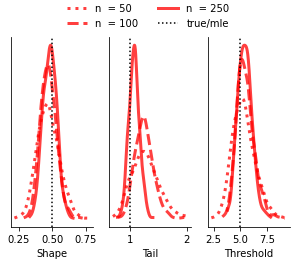

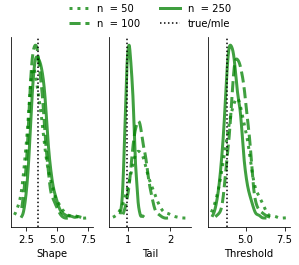

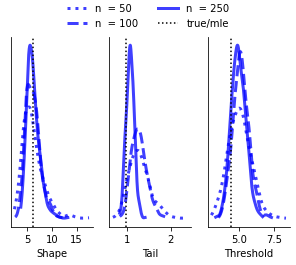

In [5]:
xlabels = ["Shape", "Tail", "Threshold"]
linetypes = ["dotted", "dashed","solid"]
colors = ["red", "green", "blue"]


for i, loss_model in enumerate(loss_models):
    fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
    for k in range(len(parms_names)):
        for j, sample_size in enumerate(sample_sizes[:3]):

            trace_temp = traces[str(sample_size)][loss_model]

            positions = np.linspace(min(trace_temp[parms_names[k]]), 
                                    max(trace_temp[parms_names[k]]), 1000)
            kernel = st.gaussian_kde(trace_temp[parms_names[k]])
            axs[k].plot(positions, kernel(positions), lw=3, label = "n  = " + str(sample_size),
                        color = colors[i] , linestyle = linetypes[j], alpha = 0.75)

            axs[k].set_yticks([])
            axs[k].set_xlabel(xlabels[k])
#             axs[k].tick_params(labelsize = font_size)

        axs[k].axvline(true_estimates[loss_model][k], color = "black", linestyle = "dotted", label = "true/mle")

    handles, labels = axs[0].get_legend_handles_labels()
#     fig.tight_layout()
    fig.legend(handles, labels, ncol = 2, borderaxespad=0., loc='upper center', 
               frameon=False)
    
    sns.despine()
    plt.savefig("../Figures/posterior_consistency_"+str(loss_model)+"_en.pdf")

In [6]:
q_post_df = pd.DataFrame()
sample_size, loss_model = 50, "lnorm-par"
for sample_size in sample_sizes[:3]:
    for loss_model in loss_models:
        trace_temp = traces[str(sample_size)][loss_model]
        temp_q_post_df = pd.DataFrame({"loss_model":np.repeat(loss_model, len(trace_temp)),
                                 'q95' : [quantile_compo(0.95, loss_model, trace_temp.iloc[k].values) for k in range(len(trace_temp))],
                                 'q99': [quantile_compo(0.99, loss_model, trace_temp.iloc[k].values) for k in range(len(trace_temp))], 
                                    'sample_size': np.repeat(sample_size, len(trace_temp))})

        q_post_df = pd.concat([q_post_df, temp_q_post_df])
q_post_df

,loss_model,q95,q99,sample_size
0,lnorm-par,16.374323,39.497491,50
1,lnorm-par,44.235073,196.565676,50
2,lnorm-par,25.215432,80.986882,50
3,lnorm-par,18.318324,54.965199,50
4,lnorm-par,23.345167,73.902579,50
...,...,...,...,...
995,gam-par,42.992416,185.011023,250
996,gam-par,37.566878,156.687809,250
997,gam-par,28.876209,96.375469,250
998,gam-par,48.321812,233.369368,250


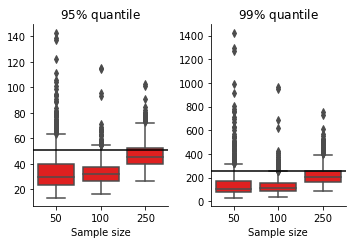

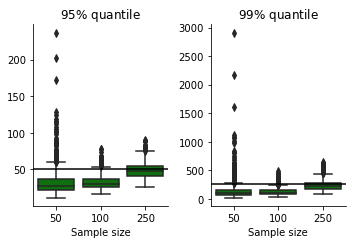

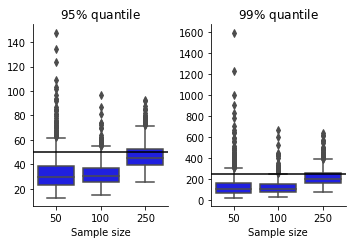

In [7]:
loss_model = "lnorm-par"
# font_size = 14
for k, loss_model in enumerate(loss_models):
    fig, axs = plt.subplots(1, 2, figsize=(5, 3.5))
    selec = np.where((q_post_df['loss_model'] == loss_model).values)
    sns.boxplot(x="sample_size", y="q95", data=q_post_df.iloc[selec] ,order = sample_sizes[:3], ax = axs[0], color = colors[k])
    sns.boxplot(x="sample_size", y="q99", data=q_post_df.iloc[selec] ,order = sample_sizes[:3],  ax = axs[1], color = colors[k])
    # axs[0].set_ylim((q_post_df.iloc[selec]['q95'].quantile(0), q_post_df.iloc[selec]['q95'].quantile(0.95)))
    axs[0].axhline(quantile_compo(0.95, 'lnorm-par', params_true), color = "black")
    axs[0].set_xlabel("Sample size")
    axs[1].set_xlabel("Sample size")
    axs[0].set_ylabel("")
    axs[1].set_ylabel("")
    axs[0].set_title("$95\%$ quantile")
    axs[1].set_title("$99\%$ quantile")
#     axs[0].tick_params(labelsize = font_size)
#     axs[1].tick_params(labelsize = font_size)
    # axs[1].set_ylim((q_post_df.iloc[selec]['q99'].quantile(0), q_post_df.iloc[selec]['q99'].quantile(0.95)))
    fig.tight_layout()
    axs[1].axhline(quantile_compo(0.99, 'lnorm-par', params_true), color = "black")
    sns.despine()
    plt.savefig("../Figures/quantile_consistency_"+str(loss_model)+"_en.pdf")

# 


# Consistency of the model selection

In [8]:
sample_sizes =[50, 100, 250, 500]

In [9]:
np.random.seed(333)
X = sim_lnorm_par(max(sample_sizes), σ_true, α_true, θ_true)
fits = []
for sample_size in sample_sizes:
    print("the sample size is " +str(sample_size))
    # Prior settings
    model_prior, a, b =  "gamma", 0.1 * np.ones(3), 0.1 * np.ones(3)
    # SMC settings
    popSize, verbose, smc_method = 1000, False, "likelihood_anealing"

    K = 1000
    def par_compare_models(i):
        X = sim_lnorm_par(sample_size, σ_true, α_true, θ_true)
        trace, summary = fit_composite_models_smc(X[:sample_size],loss_models, model_prior, a, b, popSize, verbose, smc_method, False, 4)
        summary["n_simu"] = i
        summary["q95_emp"] = np.quantile(X, 0.95)
        summary["q99_emp"] = np.quantile(X, 0.99)
        return(summary)
    res = pd.concat(Parallel(n_jobs=40)(delayed(par_compare_models)(i) for i in range(K)))
    res['index'] =  np.arange(0, K * 3, 1)
    fits.append(res)


the sample size is 50
the sample size is 100
the sample size is 250
the sample size is 500


In [10]:
q_dfs = []
for res in fits:
    VaRs = pd.DataFrame(np.array([[quantile_compo(0.95, res['loss_model'].iloc[k], res[parms_names].iloc[k].values), 
     quantile_compo(0.99, res['loss_model'].iloc[k], res[parms_names].iloc[k].values )] for k in range(len(res))]), 
                        index = np.arange(0, K * 3, 1))
    VaRs.columns = ['q95_compo', 'q99_compo']
    VaRs.reset_index()
    res1 = pd.merge(res, VaRs.reset_index()).set_index('index')
    res1['q95_weighted'] = res1['q95_compo'] * res1['model_evidence']
    res1['q99_weighted'] = res1['q99_compo'] * res1['model_evidence']
    q_ens = res1[['n_simu', 'q95_weighted', 'q99_weighted']].groupby('n_simu').sum().reset_index().rename(columns = {"q95_weighted":"q95",                                                                                                             "q99_weighted":"q99"})
    q_ens['loss_model'] = "BMA"
    q_ens
    q_emp = res1[['n_simu', 'q95_emp', 'q99_emp']].drop_duplicates().rename(columns = {'q95_emp':'q95', 'q99_emp':'q99'})
    q_emp['loss_model'] = 'empirical'
    q_compo = res1[['n_simu','loss_model','q95_compo','q99_compo']].rename(columns = {'q95_compo':'q95', 'q99_compo':'q99'})
    q_df = pd.concat([q_ens, q_emp, q_compo])
    q_df['AEq95'] = abs(q_df['q95'] - quantile_compo(0.95, 'lnorm-par', params_true) )
    q_df['AEq99'] = abs(q_df['q99'] - quantile_compo(0.99, 'lnorm-par', params_true) )
    q_df['Eq95'] = q_df['q95'] - quantile_compo(0.95, 'lnorm-par', params_true) 
    q_df['Eq99'] = q_df['q99'] - quantile_compo(0.99, 'lnorm-par', params_true) 
    q_dfs.append(q_df)

In [11]:
q_df_list = []
custom_dict = {'empirical': 0, 'lnorm-par': 1, 'wei-par': 2, 'gam-par': 3, "BMA":4 } 
for q_df in q_dfs:
    q_df_list.append(q_df[['loss_model', 'AEq95', 'AEq99']].groupby('loss_model').mean())

print(
    pd.concat(q_df_list, axis = 1).reset_index().sort_values(by=['loss_model'], 
                                                             key=lambda x: x.map(custom_dict)).set_index('loss_model').to_latex(float_format="%.2f")
)


\begin{tabular}{lrrrrrrrr}
\toprule
{} &  AEq95 &  AEq99 &  AEq95 &  AEq99 &  AEq95 &  AEq99 &  AEq95 &  AEq99 \\
loss\_model &        &        &        &        &        &        &        &        \\
\midrule
empirical  &  24.31 & 375.45 &  17.88 & 204.65 &  10.93 & 122.90 &   7.72 &  83.85 \\
lnorm-par  &  25.49 & 248.46 &  15.11 & 135.23 &   8.48 &  70.14 &   6.13 &  50.54 \\
wei-par    &  23.99 & 220.50 &  16.12 & 147.35 &   9.12 &  78.89 &   6.77 &  59.19 \\
gam-par    &  21.99 & 192.59 &  15.06 & 131.70 &   8.66 &  72.14 &   6.29 &  52.70 \\
BMA        &  24.36 & 230.26 &  15.36 & 137.59 &   8.65 &  72.22 &   6.24 &  51.99 \\
\bottomrule
\end{tabular}



<Figure size 432x288 with 0 Axes>

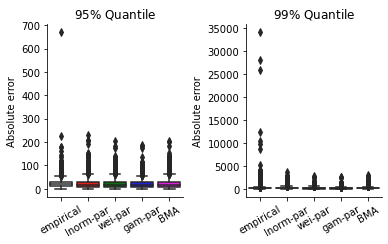

<Figure size 432x288 with 0 Axes>

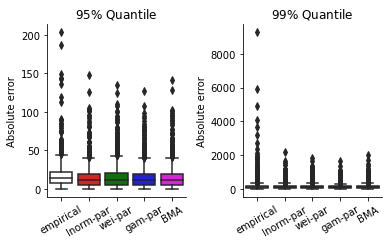

<Figure size 432x288 with 0 Axes>

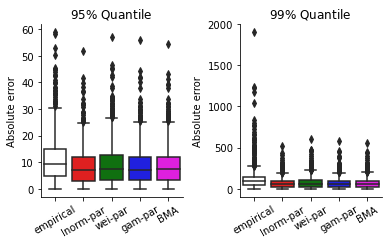

<Figure size 432x288 with 0 Axes>

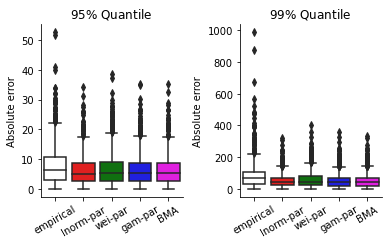

In [12]:

for k, q_df in enumerate(q_dfs):
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(5.5, 3.5))
    sns.boxplot(x="loss_model", y="AEq95", data=q_df,order = ['empirical'] +  loss_models + ['BMA'] ,
                palette = ["white", "red", "green", "blue", "magenta"], ax = axs[0])
    sns.boxplot(x="loss_model", y="AEq99", data=q_df,order = ['empirical'] +  loss_models + ['BMA'] ,
                palette = ["white", "red", "green", "blue", "magenta"], ax = axs[1])
    for i in range(2):
#         axs[k].set_title( "Absolute error")
        axs[i].set_xlabel("")
        
        axs[i].set_ylabel("Absolute error")
        axs[i].tick_params( rotation = 30, axis = 'x')
        axs[i].tick_params( axis = 'y')
    axs[0].set_title( "$95\%$ Quantile")
    axs[1].set_title( "$99\%$ Quantile")
    fig.tight_layout()
    sns.despine()
    plt.savefig("../Figures/q_lnorm_par_"+str(sample_sizes[k])+"_en.pdf")
    plt.show()
    

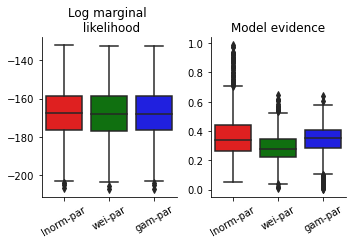

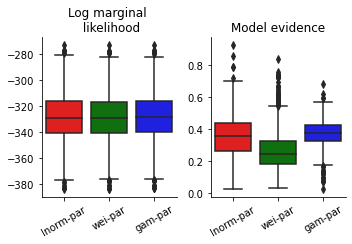

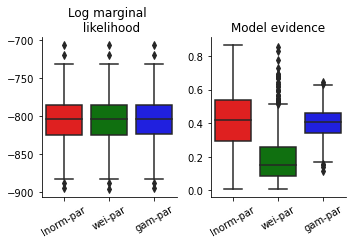

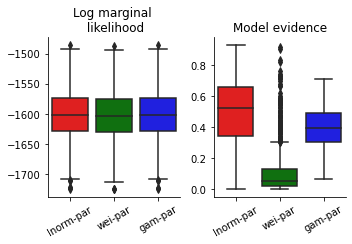

In [13]:
# Boxplots of marginal log likelihood and model evidence
font_size = 14
for k, res in enumerate(fits):

#     plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(5, 3.5))
    sns.boxplot(x="loss_model", y = "log_marg", data = res, ax = axs[0], palette = colors)
    sns.boxplot(x="loss_model", y = "model_evidence", data = res, ax = axs[1], palette = colors)
    for i in range(2):
        axs[i].tick_params( axis = 'x', rotation = 30)
        axs[i].tick_params(axis = 'y')
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    axs[0].set_title( "Log marginal \n likelihood")
    axs[1].set_title( "Model evidence")  
    fig.tight_layout()
    sns.despine()
    plt.savefig("../Figures/log_marg_lnorm_par_"+str(sample_sizes[k])+"_en.pdf")
    plt.show()

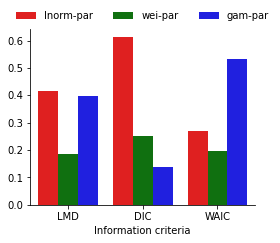

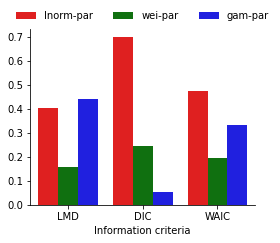

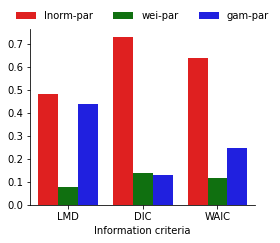

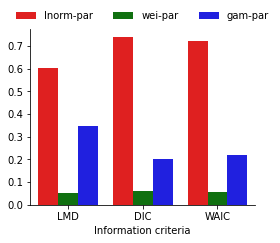

In [14]:
for k, res in enumerate(fits):
    ICs = ["LMD", "DIC", "WAIC"]
    res["LMD"] = - res["log_marg"]
    df_IC_min = res.groupby('n_simu')[["LMD", "DIC", "WAIC"]].min().rename_axis("n_simu").reset_index().\
    rename(columns={"LMD":"LMD_min", "DIC": "DIC_min", "WAIC":"WAIC_min"})
    res_V1 = pd.merge(res, df_IC_min, how="inner", on  = "n_simu")
    n_selected_models = pd.DataFrame(columns = ["IC", "loss_model", "prop"])
    for IC in ICs:
        for loss_model in loss_models:
            n_selected_models = pd.concat([n_selected_models,
                   pd.DataFrame({"IC": [IC], "loss_model": [loss_model], 
                      "prop":np.sum(res_V1.loss_model[res_V1[IC] == res_V1[IC+"_min"]].values == loss_model) / K})])
    fig, axs = plt.subplots(1, 1, figsize=(4, 3.5))
    sns.barplot(x="IC", y="prop", hue = "loss_model",data = n_selected_models, hue_order = loss_models,
                  palette = colors, dodge = True)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),  loc="upper center", borderaxespad=0., ncol = 3,  frameon = False, 
               markerscale = 1.5)
    plt.xlabel("Information criteria")
    plt.ylabel("")
    fig.tight_layout()
    sns.despine()
    plt.savefig("../Figures/IC_lnorm_par_"+str(sample_sizes[k])+"_en.pdf")
    plt.show()
